In [1]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics
from oggm.core import massbalance
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import igm

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

## Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

## Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed_', reset=True)

## Pick a glacier
rgi_ids = ['RGI60-11.01450']  # This is Aletsch
# rgi_ids = ['RGI60-11.00897']  # This is Hintereisferner
# rgi_ids = ['RGI60-11.03638']  # This is Argentiere
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/exps/igm_v2'

gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=base_url, from_prepro_level=3, prepro_border=40)[0]


2024-08-21 16:57:06: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-08-21 16:57:06: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-08-21 16:57:06: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-08-21 16:57:06: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-08-21 16:57:06: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [2]:
from oggm.shop import cook23
cook23.cook23_to_gdir(gdir)

### Activate the 3 lines of code in the following code block to use the match with the consensus volume (Farinotti et al. 2019)

In [3]:
# match of consensus
# ### Recompute the volume to match Farinotti et al. 2019 (for consistency with IGM later) 
# from oggm.global_tasks import calibrate_inversion_from_consensus
# calibrate_inversion_from_consensus([gdir])
# get ready for modelling
# tasks.init_present_time_glacier(gdir)

In [4]:
# Do a random run with a bit of warming
tasks.run_random_climate(gdir, nyears=100, 
                         y0=2009, halfsize=10, # Climate of 1999-2019
                         seed=1,  # Change for another randomness 
                         temperature_bias=0,  # casual warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         output_filesuffix='_rdn_1',  # name the run
                        );

In [5]:
mb = massbalance.RandomMassBalance(gdir,
                                   y0=2009, halfsize=10, # Climate of 1999-2019
                                   seed=1,  # Change for another randomness 
                                   )

In [6]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as gd:
    gd = gd.load()

# set values outside the glacier to np.nan
# using the glacier mask, as otherwise there is more ice from surrounding glaciers in the domain, 
# which shouldn't accumulate more ice, still adds to the total volume/area of the domain.. either mask it out beforehand or before doing plots.
# experiment with it: does the mass outside of the mask only decrease? => ?
gd['cook23_thk_masked'] = xr.where(gd.glacier_mask, gd.cook23_thk, np.nan)



In [7]:
bed_con = gd.topo - gd.consensus_ice_thickness.fillna(0)
bed_cook_masked = gd.topo - gd.cook23_thk_masked.fillna(0)
bed_cook = gd.topo - gd.cook23_thk

In [8]:
############################### OGGM-IGM - CONSENSUS
from igm.instructed_oggm import IGM_Model2D

sdmodel_igm_con = IGM_Model2D(bed_con.values, init_ice_thick=gd.consensus_ice_thickness.fillna(0).values, 
                     dx=gdir.grid.dx, dy=gdir.grid.dy, x=bed_con.x, y=bed_con.y, mb_model=mb, 
                        y0=0., mb_filter=gd.glacier_mask.values==1)

dsr_igm_con = sdmodel_igm_con.run_until_and_store(100, grid=gdir.grid)

2024-08-21 16:57:08.092831: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-21 16:57:08.092859: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-21 16:57:08.092868: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-21 16:57:08.092908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-21 16:57:08.092926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found pretrained emulator in the igm package: pinnbp_10_4_cnn_16_32_2_1


/Users/afisc/igm_venv/lib/python3.10/site-packages/tensorflow/python/framework/tensor_util.py:518: RuntimeWarning: overflow encountered in cast
  nparray = np.array(values, dtype=np_dt)
2024-08-21 16:57:10.295575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [9]:
############################### OGGM-IGM - COOK_23
sdmodel_igm_cook = IGM_Model2D(bed_cook.values, init_ice_thick=gd.cook23_thk.fillna(0).values, 
                     dx=gdir.grid.dx, dy=gdir.grid.dy, x=bed_cook.x, y=bed_cook.y, mb_model=mb, 
                        y0=0., mb_filter=gd.glacier_mask.values==1)

dsr_igm_cook = sdmodel_igm_cook.run_until_and_store(100, grid=gdir.grid)

Found pretrained emulator in the igm package: pinnbp_10_4_cnn_16_32_2_1


In [10]:
############################### OGGM-IGM - COOK_23 MASKED
sdmodel_igm_cook_masked = IGM_Model2D(bed_cook_masked.values, init_ice_thick=gd.cook23_thk_masked.fillna(0).values, 
                     dx=gdir.grid.dx, dy=gdir.grid.dy, x=bed_cook_masked.x, y=bed_cook_masked.y, mb_model=mb, 
                        y0=0., mb_filter=gd.glacier_mask.values==1)

dsr_igm_cook_masked = sdmodel_igm_cook_masked.run_until_and_store(100, grid=gdir.grid)

Found pretrained emulator in the igm package: pinnbp_10_4_cnn_16_32_2_1


In [11]:
with xr.open_dataset(gdir.get_filepath('fl_diagnostics', filesuffix='_rdn_1'), group=f'fl_0') as ds:
    ds = ds.load()

In [12]:
# ## Redistribute: preprocessing
# The required tasks can be found in the `distribute_2d` module of the sandbox:
from oggm.sandbox import distribute_2d

# This is to add a new topography to the file (smoothed differently)
distribute_2d.add_smoothed_glacier_topo(gdir)
# This is to get the bed map at the start of the simulation
tasks.distribute_thickness_per_altitude(gdir)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
distribute_2d.assign_points_to_band(gdir)

# ## Redistribute simulation
# The tasks above need to be run only once. The next one however should be done for each simulation:
distribute_2d.distribute_thickness_from_simulation(gdir, input_filesuffix='_rdn_1')
with xr.open_dataset(gdir.get_filepath('gridded_simulation', filesuffix='_rdn_1')) as gs:
    gs = gs.load()

In [13]:
type(gdir.rgi_date)

int

In [14]:
for df in [ds, dsr_igm_con, dsr_igm_cook, dsr_igm_cook_masked]:
    df.coords['time'] = df.coords['time'] + gdir.rgi_date


In [15]:
# just for showing how the ice evolution is outside of the actual glacier domain. should be constantly decreasing due to the mb_filter
# glacier_mask = gd.glacier_mask.expand_dims(time=dsr_igm_cook.time)
# dsr_igm_cook['inverted_masked_ice_thickness'] = dsr_igm_cook.ice_thickness.where(~glacier_mask)

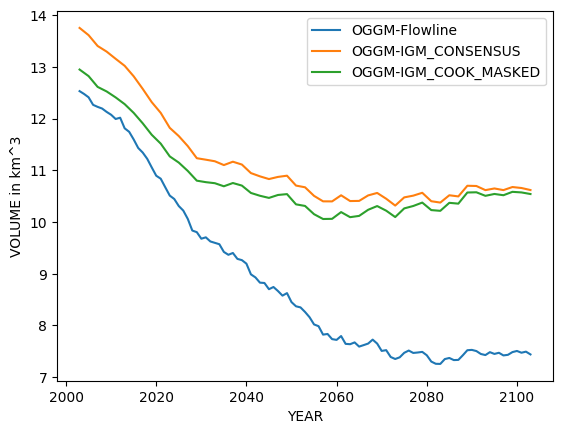

In [16]:
# comparison plots
# OGGM Flowline
(ds.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline');

# IGM (from consensus volume)
(dsr_igm_con.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM_CONSENSUS');

# IGM (from cook23 volume)
# (dsr_igm_cook.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM_COOK');
# (dsr_igm_cook.inverted_masked_ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM_COOK_outside_aletsch');

# # IGM (from cook23 volume) - MASKED
(dsr_igm_cook_masked.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM_COOK_MASKED');


plt.ylabel('VOLUME in km^3')
plt.xlabel('YEAR')
# plt.xlim(2000, 2030)
# plt.ylim(8, 15)
plt.legend();

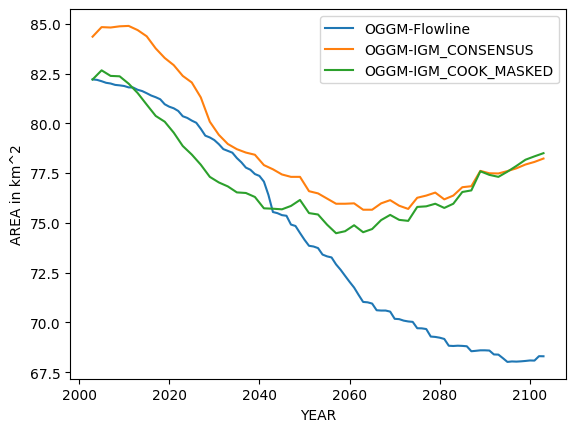

In [17]:
(ds.area_m2.sum(dim=['dis_along_flowline'])*1e-6).plot(label='OGGM-Flowline');
((dsr_igm_con.ice_thickness > 1).sum(dim=['x', 'y']) *gdir.grid.dx**2*1e-6).plot(label='OGGM-IGM_CONSENSUS');
# ((dsr_igm_cook.ice_thickness > 1).sum(dim=['x', 'y']) *gdir.grid.dx**2*1e-6).plot(label='OGGM-IGM_COOK');
((dsr_igm_cook_masked.ice_thickness > 1).sum(dim=['x', 'y']) *gdir.grid.dx**2*1e-6).plot(label='OGGM-IGM_COOK_MASKED');
# ((dsr_igm_cook.inverted_masked_ice_thickness > 1).sum(dim=['x', 'y']) *gdir.grid.dx**2*1e-6).plot(label='OGGM-IGM_COOK_outside_glaicer');
plt.ylabel('AREA in km^2')
plt.xlabel('YEAR')
# plt.xlim(2000, 2030)
# plt.ylim(75, 90)
plt.legend();
